In [1]:
!pip install openai
import openai

In [76]:
import os
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pdf

In [77]:
# read my key from file openai_key.txt
with open('../../keys/openai_gpt_siji.txt', 'r') as file:
    key = file.read().replace('\n', '')


In [78]:
client = OpenAI(
    # This is my API key, you should use your own
    api_key=key
)

def get_chat_completion(messages,client=client, model="gpt-3.5-turbo-0125", max_tokens=12000, store=True):
    # the cheapest model I could find; input $0.0005 / 1K tokens; output $0.0015 / 1K tokens
    chat_completion= client.chat.completions.create(
        messages=[
            {"role":"system","content":"You are a data scientist working on anomaly detection."},
             {
            "role": "user",
            "content": messages,
        }
            ],
        model=model,
        temperature=0,
        max_tokens=max_tokens,
        store=store,
    )
    return chat_completion

MODEL_LIST=["gpt-4o","gpt-4o-mini","gpt-4-turbo","gpt-3.5-turbo-0125"]


In [79]:
def print_response(response, debug=False):
    if debug:
        # print the tokens size
        print('total tokens:', response.usage.total_tokens, 'prompt tokens:', response.usage.prompt_tokens, 'completion_tokens tokens:', response.usage.completion_tokens)
    print(response.choices[0].message.content)
    

In [80]:
# read file
import pandas as pd
df = pd.read_csv('data/data_selection_17_23_drop_missing_nodes_dropna.csv')
# drop some node_id: 5,8,15,18,20,50
# df = df[~df['nodeid'].isin([5,8,15,18,20,50])]

# # temperature keeps only 2 decimal points
# df['temperature'] = df['temperature'].round(2)
# df['humidity'] = df['humidity'].round(2)
# # drop column light
# df = df.drop(columns=['light'])

# df = df.dropna()
# df['voltage'] = df['voltage'].round(2)
# # save to csv
# df.to_csv('data/data_selection_17_23_drop_missing_nodes_dropna.csv', index=False)


In [90]:
one_hour=120 # sample every 30 seconds, one hour has 120 samples
one_day=one_hour*24
# df_first_10_nodesid = df[df['nodeid'].isin([1])]
sample=df[np.logical_and(df['timestamp']>one_hour*10,df['timestamp']<one_hour*15)]
print(sample.shape)
# df_first_10_nodesid

(3449, 5)


In [91]:
# df_first_10_nodesid = df[df['nodeid'].isin([1])]

# dataset=df_first_10_nodesid[:2880]
# set timestamp as index
# dataset.set_index('timestamp', inplace=True)
# drop nodeid
# dataset=dataset.drop(columns=['nodeid'])
# print(dataset )
# # change dataset into json format
# dataset_json_temperature=dataset['temperature'].to_json(orient="split",index=False) # this taks too much token
# dataset_json_humidity=dataset['humidity'].to_json(orient="split",index=False)
# dataset_json_volt=dataset['voltage'].to_json(orient="split",index=False)
# # index only
# dataset_json_timestamp=dataset['timestamp'].to_json(orient="split",index=False)
# index sample using timestamp and nodeid
# sample=sample.set_index(['timestamp','nodeid'])

sample_json=sample.to_json(orient="split",index=False)
print(len(sample_json))
print(sample_json)

91359
{"columns":["timestamp","nodeid","temperature","humidity","voltage"],"data":[[1207,1,21.81,34.64,2.49],[1207,2,22.33,35.23,2.46],[1207,3,21.89,35.02,2.5],[1207,10,22.36,34.33,2.5],[1207,13,19.93,39.01,2.44],[1207,34,23.26,32.72,2.47],[1207,35,22.92,35.4,2.39],[1207,54,22.85,31.07,2.49],[1208,39,24.57,29.97,2.52],[1210,27,25.44,28.97,2.52],[1210,45,20.68,35.02,2.47],[1211,30,26.78,27.29,2.54],[1211,43,24.05,29.54,2.5],[1212,10,22.36,34.29,2.49],[1212,11,22.48,34.47,2.47],[1212,41,25.82,26.28,2.52],[1213,43,24.04,29.54,2.51],[1213,51,20.74,34.33,2.47],[1216,12,23.28,31.6,2.49],[1217,1,21.98,34.4,2.5],[1217,22,21.94,34.12,2.46],[1217,32,23.11,32.62,2.5],[1217,35,23.06,35.09,2.39],[1217,54,22.88,31.24,2.49],[1218,12,23.34,31.53,2.49],[1219,31,25.92,28.65,2.54],[1225,7,20.76,36.61,2.47],[1225,24,23.26,31.38,2.5],[1225,54,22.93,30.96,2.49],[1226,12,23.28,31.53,2.49],[1227,37,23.57,34.61,2.5],[1230,46,19.99,36.72,2.35],[1230,54,22.94,30.85,2.49],[1231,3,21.93,34.64,2.49],[1231,33,22.71,

In [92]:
single_point_shifts_dramatically=[24.37, 90.92, 24.42, 24.41]
multiple_points_oscillate=[36.64, 71.76, 49.87, 77.15, 94.38]
persistent_level_shift=[]
few_shots_promt=f"""
You are a data scientist working on anomaly detection. The dataset is below in json format. 
You're looking for anomalies in 3 columns: "temperature","humidity","voltage". 
Please analyze the data with the highest level of diligence and caution.
Use your knowledge about temperature, humidity and battery voltage to find anomaly.
Anomaly Types definitions:
    - Single point shifts dramatically from other points. example: {single_point_shifts_dramatically}
    - Multiple points oscillate. example: {multiple_points_oscillate}
    - Persistent level shift. 
Brief me your thought in each step. But don't return the code.
Directly give me the results. The anomalies for the three columns the csv format: [timestamp, nodeid,temperature_anomaly, humidity_anomaly, voltage_anomaly] format. Use 0 indicates normal and 1 indicates anomaly. 
If given timestamp and nodeid has normal for all three columns, don't include it in the csv.

Data: ```{sample_json}```.
"""
print(len(few_shots_promt))
print(few_shots_promt)

92307

You are a data scientist working on anomaly detection. The dataset is below in json format. 
You're looking for anomalies in 3 columns: "temperature","humidity","voltage". 
Please analyze the data with the highest level of diligence and caution.
Use your knowledge about temperature, humidity and battery voltage to find anomaly.
Anomaly Types definitions:
    - Single point shifts dramatically from other points. example: [24.37, 90.92, 24.42, 24.41]
    - Multiple points oscillate. example: [36.64, 71.76, 49.87, 77.15, 94.38]
    - Persistent level shift. 
Brief me your thought in each step. But don't return the code.
Directly give me the results. The anomalies for the three columns the csv format: [timestamp, nodeid,temperature_anomaly, humidity_anomaly, voltage_anomaly] format. Use 0 indicates normal and 1 indicates anomaly. 
If given timestamp and nodeid has normal for all three columns, don't include it in the csv.

Data: ```{"columns":["timestamp","nodeid","temperature","hum

In [95]:
response = get_chat_completion(few_shots_promt,model=MODEL_LIST[2],max_tokens=4096)
print_response(response, debug=True)

total tokens: 59515 prompt tokens: 58907 completion_tokens tokens: 608
After analyzing the data for anomalies in the "temperature," "humidity," and "voltage" columns, here are the findings in CSV format:

```
timestamp,nodeid,temperature_anomaly,humidity_anomaly,voltage_anomaly
1207,13,1,1,0
1207,35,0,0,1
1211,30,1,1,0
1230,46,1,1,1
1257,49,1,1,1
1258,6,0,0,1
1265,13,1,1,0
1268,13,1,1,1
1275,46,1,1,1
1278,25,1,1,0
1285,30,1,1,0
1286,44,1,1,0
1290,4,0,0,1
1317,17,1,1,1
1323,25,1,1,0
1342,28,0,0,1
1356,46,1,1,1
1372,25,1,1,0
1381,48,1,1,0
1393,47,1,1,0
1428,25,1,1,0
1458,19,1,1,1
1463,25,1,1,0
1464,30,1,1,0
1467,30,1,1,0
1482,25,1,1,0
1487,28,1,1,0
1492,40,0,0,1
1515,17,1,1,1
1518,17,1,1,1
1521,17,1,1,1
1522,21,1,1,0
1523,17,1,1,1
1524,17,1,1,1
1525,25,1,1,0
1534,16,1,1,1
1555,16,1,1,1
```

**Explanation:**
- The anomalies were detected based on significant deviations from typical values observed in the dataset.
- For temperature and humidity, anomalies were considered when values were s

In [117]:

file_id='file-Vw1SqTko876Ga6mEBT22Sv'
vanilla_promt=f"""
You are a data scientist working on anomaly detection. The dataset is below with 4 channels:"timestamp","temperature","humidity","voltage".
You're looking for anomalies in 3 channels: "temperature","humidity","voltage". 
Brief me your thought in each step in less than 20 words. 
Don't show me the code you used to find the anomalies.
Return the anomalies for the three channels's corresponding timestamp in the format: column:[timestamp] format. 
Data: ```{dataset_json_timestamp}``` ```{dataset_json_temperature}``` ```{dataset_json_humidity}``` ```{dataset_json_volt}```.
"""
print(len(vanilla_promt))
print(vanilla_promt)

63510

You are a data scientist working on anomaly detection. The dataset is below with 4 channels:"timestamp","temperature","humidity","voltage".
You're looking for anomalies in 3 channels: "temperature","humidity","voltage". 
Brief me your thought in each step in less than 20 words. 
Don't show me the code you used to find the anomalies.
Return the anomalies for the three channels's corresponding timestamp in the format: column:[timestamp] format. 
Data: ```{"name":"timestamp","data":[1207,1217,1237,1283,1318,1342,1367,1377,1397,1469,1478,1518,1528,1536,1539,1540,1542,1549,1553,1556,1558,1563,1565,1567,1569,1572,1578,1579,1590,1591,1592,1594,1595,1596,1598,1600,1602,1604,1606,1614,1617,1618,1624,1628,1629,1632,1636,1639,1641,1644,1647,1651,1656,1657,1659,1664,1670,1671,1673,1675,1678,1679,1680,1682,1683,1686,1687,1688,1689,1694,1696,1699,1702,1703,1704,1705,1707,1708,1714,1719,1720,1723,1725,1731,1734,1735,1737,1738,1745,1746,1750,1753,1755,1756,1758,1762,1763,1764,1769,1770,1772,177

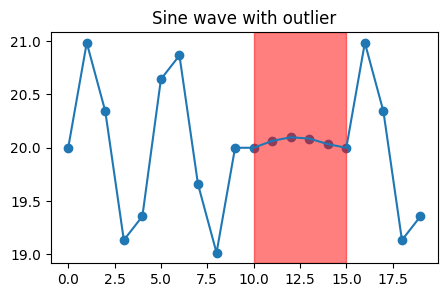

In [247]:
x,y1=sine_wave(n=10, freq=2, amp=1, phase=0)
y1=y1+20
x,y2=sine_wave(n=10, freq=10, amp=0.1, phase=0)
y2=y2+20
# concatenate the two sine waves
y=np.concatenate([y1,y2[:5],y1[:5]])
# y=y1
# y[6]=30
# set figure size
plt.figure(figsize=(5, 3))
# scatter plot
plt.plot(range(0,len(y)), y)
plt.scatter(range(0,len(y)), y)
plt.title("Sine wave with outlier")
# add vertical region to highlight the outlier
plt.axvspan(len(y1), len(y1)+5, color='red', alpha=0.5)

In [248]:
# use y as the dataset, format it as a string with 2 decimals
dataset = np.array2string(y, precision=2, separator=',',suppress_small=True)

prompt =f"""
You are a data scientist working on abnomaly detection.
The dataset you are working on is a collection of data from a sensor 
that measures the room temperature. 
Data: ```{dataset}```
Give the reason for the anomaly in less than 20 words.
Return the index and value of the anomalies in [index, value] format. 
"""

print(prompt )



You are a data scientist working on abnomaly detection.
The dataset you are working on is a collection of data from a sensor 
that measures the room temperature. 
Data: ```[20.  ,20.98,20.34,19.13,19.36,20.64,20.87,19.66,19.02,20.  ,20.  ,20.06,
 20.1 ,20.09,20.03,20.  ,20.98,20.34,19.13,19.36]```
Give the reason for the anomaly in less than 20 words.
Return the index and value of the anomalies in [index, value] format. 



In [249]:
response = get_chat_completion(prompt,model=MODEL_LIST[0])
print_response(response, debug=True)

total tokens: 212 prompt tokens: 175 completion_tokens tokens: 37
Reason: Sensor malfunction or environmental change.  
Anomalies: [[1, 20.98], [6, 20.87], [16, 20.98]]


In [195]:
# use y as the dataset, format it as a string with 2 decimals
dataset_example = np.array2string(y, precision=2, separator=',',suppress_small=True)
dataset_test = np.array2string((y+1)[1:], precision=2, separator=',',suppress_small=True)

prompt =f"""
The dataset is a collection of data from a sensor that measures the room temperature. 
Find the abnomaly as the example below
and return in [index1,index2,...] format. 
Example: Data: ```{dataset_example}``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```{dataset_test}``` Anomaly:
"""
print(prompt)


The dataset is a collection of data from a sensor that measures the room temperature. 
Find the abnomaly as the example below
and return in [index1,index2,...] format. 
Example: Data: ```[20.  ,20.98,20.34,19.13,19.36,20.64,20.87,19.66,19.02,20.  ,20.  ,20.06,
 20.1 ,20.09,20.03,20.  ,20.98,20.34,19.13,19.36]``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```[21.98,21.34,20.13,20.36,21.64,21.87,20.66,20.02,21.  ,21.  ,21.06,21.1 ,
 21.09,21.03,21.  ,21.98,21.34,20.13,20.36]``` Anomaly:



In [196]:
response = get_chat_completion(prompt,model=MODEL_LIST[1])
print_response(response, debug=True)

total tokens: 276 prompt tokens: 255 completion_tokens tokens: 21
[8, 9, 10, 11, 12, 13, 14]


In [207]:
prompt =f"""
Find the abnomaly as the example below
Example: Data: ```{dataset_example}``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```{dataset_test}``` Anomaly:
"""
from pydantic import BaseModel
class ADReponse(BaseModel):
    reason:str
    anomalies_index: list[str]
    
chat_completion= client.beta.chat.completions.parse(
    messages=[
        {"role":"system","content":"You are a data scientist working on abnomaly detection."},
            {
        "role": "user",
        "content": prompt,
    }
        ],
    model=MODEL_LIST[1],
    temperature=0,
    max_tokens=100,
    response_format=ADReponse,
    )


In [213]:
result=chat_completion.choices[0].message.parsed
print(result.reason)
anomaliy_index = result.anomalies_index
# parse the index of the anomalies into numpy array as integer
anomaliy_index = np.array(anomaliy_index)
# convert the index to integer from string
anomaliy_index = anomaliy_index.astype(int)
print(anomaliy_index)


The values from index 10 to 14 are significantly different from the surrounding values, indicating an anomaly.
[10 11 12 13 14]


In [215]:
# what is the model
print(response.model)

gpt-4o-2024-08-06


## chain of thought

In [217]:
from pydantic import BaseModel
from openai import OpenAI



class Step(BaseModel):
    explanation: str
    output: str

class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

completion = client.beta.chat.completions.parse(
    model=MODEL_LIST[1],
    messages=[
        {"role": "system", "content": "You are a helpful math tutor. Guide the user through the solution step by step."},
        {"role": "user", "content": "how can I solve 8x + 7 = -23"}
    ],
    response_format=MathReasoning,
)

math_reasoning = completion.choices[0].message.parsed

SyntaxError: positional argument follows keyword argument (3042263013.py, line 21)

In [199]:
math_reasoning

MathReasoning(steps=[Step(explanation='We want to isolate the term with x, so we first subtract 7 from both sides of the equation.', output='8x + 7 - 7 = -23 - 7'), Step(explanation='Simplifying the left side gives us 8x, and simplifying the right side gives us -30.', output='8x = -30'), Step(explanation='Now, we need to solve for x by dividing both sides of the equation by 8.', output='x = -30 / 8'), Step(explanation='Simplifying -30/8 by dividing both the numerator and the denominator by 2 gives us -15/4.', output='x = -15/4')], final_answer='x = -15/4')

In [216]:
completion.choices[0].message.refusal